In [1]:
import pandas as pd
import datetime
from datetime import datetime

In [2]:
data=pd.read_csv('logistique.csv')

## Afficher la data

In [3]:
data

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.9930000,48,02/11/2019
1,2019-11-01 11:40:35.9700000,48,02/11/2019
2,2019-11-01 10:24:40.8930000,48,02/11/2019
3,2019-11-01 14:24:21.1770000,48,02/11/2019
4,2019-11-01 13:28:35.7900000,48,02/11/2019
...,...,...,...
572836,2019-12-16 06:12:25.2170000,48,17/12/2019
572837,2019-12-16 06:12:25.4630000,48,17/12/2019
572838,2019-12-15 22:32:36.3200000,48,17/12/2019
572839,2019-12-15 20:06:55.0670000,48,17/12/2019


## Explorer la Data

In [4]:
data.describe().T
#Avec cette commande on n'arrive pas à avoir des information exploitable car les features sont deux strings 
#et un int qui n'en ai pas vraiment un car c'est un id et non pas une donnée ordonnable

,count,mean,std,min,25%,50%,75%,max
providerservice_id,572841.0,41.307515,13.523457,5.0,48.0,48.0,48.0,92.0


## Nettoyer la Data

In [5]:
from datetime import date,  timedelta
from calendar import SATURDAY,  SUNDAY

def parse1(my_date):
    """Date of type 01/11/2019"""
    d, m, y = map(int, my_date.split('/'))
    #print(date(y, m, d))
    return date(y, m, d)

def parse2(my_date):
    """Date of type 2019-11-01 11:40:35.993000"""
    date1,heure=my_date.split(' ')
    y, m, d = map(int, date1.split('-'))
    return date(y, m, d)
 
def days_diff(date_1, date_2):
    return ((parse1(date_1) - parse2(date_2)).days)

#test
a="02/11/2019"
b="2019-11-01 11:40:35.9930000"
n_days = days_diff(a,b) 
print(n_days)

1


In [6]:
#Ici on supprime les lignes où la date d'expédition est antérieur à la date de commande
k=[]
for i in data.index :
    dateexpe=data["dateexpe"].values[i]
    datecommande=data["datedecreationdecommande"].values[i]
    n_days = days_diff(dateexpe,datecommande)
    if (n_days<0):
        k.append(i)
        #data.drop(data.index[[i]])

In [7]:
data=data.drop(data.index[k])

In [8]:
data.shape
len(data)

572807

## Créer la Target

##### On va créé une target qui donne le délais entre le jour de commande et le jour d'expédition


In [9]:
delais=[]
for i in range(len(data)):
    datecommande=data["dateexpe"].values[i]
    dateexpe=data["datedecreationdecommande"].values[i]
    n_days = days_diff(datecommande,dateexpe) 
    delais.append(n_days)

In [10]:
data['délais']=delais

In [11]:
data[data['délais']>6]

,datedecreationdecommande,providerservice_id,dateexpe,délais
62921,2019-11-07 21:38:41.8370000,7,14/11/2019,7
77520,2019-11-07 05:00:39.1870000,48,22/11/2019,15
105552,2019-12-02 19:32:35.6030000,7,09/12/2019,7
105553,2019-12-02 19:22:00.2030000,7,09/12/2019,7
105554,2019-12-02 18:58:34.6030000,7,09/12/2019,7
...,...,...,...,...
537035,2019-12-02 20:03:58.0200000,48,09/12/2019,7
537037,2019-12-02 23:03:43.6530000,48,09/12/2019,7
537042,2019-12-02 23:16:50.8000000,48,09/12/2019,7
546222,2019-12-02 15:15:57.4500000,48,09/12/2019,7


##### On explore la target en fonctions des paramètres exixtants

In [12]:
data['délais'].describe()
#On remarque que le délais évolue entre 0 et 15 jours
#Et que la moyenne était d'environ 2,32 jours

count    572807.000000
mean          2.317589
std           1.236173
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: délais, dtype: float64

In [13]:
data[(data['délais']>6)]
#On remarque qu'il y a 3170 commandes qui ont un délais d'attente 
#entre la date de commande et la date d'expédition sup à 1 semaine

data[(data['délais']>6) & (data['providerservice_id']!=7) & (data['providerservice_id']!=48)
     & (data['providerservice_id']!=42)  & (data['providerservice_id']!=21)]
#Et on remarque que les provider service qui ont ces délais sont le 7, 21, 42 et le 48

,datedecreationdecommande,providerservice_id,dateexpe,délais


In [14]:
ps_sup6={}
for i in  data[(data['délais']>6)].index:
    #print(i-2)
    if (data.iloc[i-2,1]) not in ps_sup6:
            ps_sup6[data.iloc[i-2,1]]=1
    else:
            ps_sup6[data.iloc[i-2,1]]=ps_sup6[data.iloc[i-2,1]]+1

In [15]:
ps_sup6

{7: 1696, 48: 844, 42: 383, 21: 240, 16: 5, 92: 1, 5: 1}

In [16]:
data[(data['délais']==0) ==True]
#On remarque qu'il y a 14474  commandes qui ont un délais d'attente 
#entre la date de commande et la date d'expédition de 0 jour


#On regarde qu'elles sont les provider service les plus rapides
ps_0={}
for i in  data[(data['délais']==0)].index:
     if (data.iloc[i-2,1]) not in ps_0:
            ps_0[data.iloc[i-2,1]]=0
     if (data.iloc[i-2,1]) in ps_0:
            ps_0[data.iloc[i-2,1]]=ps_0[data.iloc[i-2,1]]+1


In [17]:
ps_0
#On remarque que les plus rapides sont le 48 le 21 et le 16

{48: 8806, 21: 2510, 7: 499, 16: 1778, 92: 694, 20: 64, 42: 123}

In [18]:
ps_15={}
for i in  data[(data['délais']==15)].index:
    print(i)
    if (data.iloc[i-2,1]) not in ps_15:
            ps_15[data.iloc[i-2,1]]=0
    if (data.iloc[i-2,1]) in ps_15:
            ps_15[data.iloc[i-2,1]]=ps_15[data.iloc[i-2,1]]+1


77520


In [65]:
#On cherche à savoir le temps moyen de chaque providerservice_id
data.groupby('providerservice_id')['délais'].mean().round(0)

providerservice_id
5     3.0
7     3.0
16    1.0
20    1.0
21    2.0
42    3.0
48    2.0
92    0.0
Name: délais, dtype: float64

In [66]:
#On cherche à savoir le temps maximum de chaque providerservice_id
data.groupby('providerservice_id')['délais'].max().round(0)

providerservice_id
5      5
7      8
16     4
20     5
21     8
42     7
48    15
92     3
Name: délais, dtype: int64

In [67]:
#On cherche à savoir le temps minimum de chaque providerservice_id
data.groupby('providerservice_id')['délais'].min().round(0)

providerservice_id
5     1
7     0
16    0
20    0
21    0
42    0
48    0
92    0
Name: délais, dtype: int64

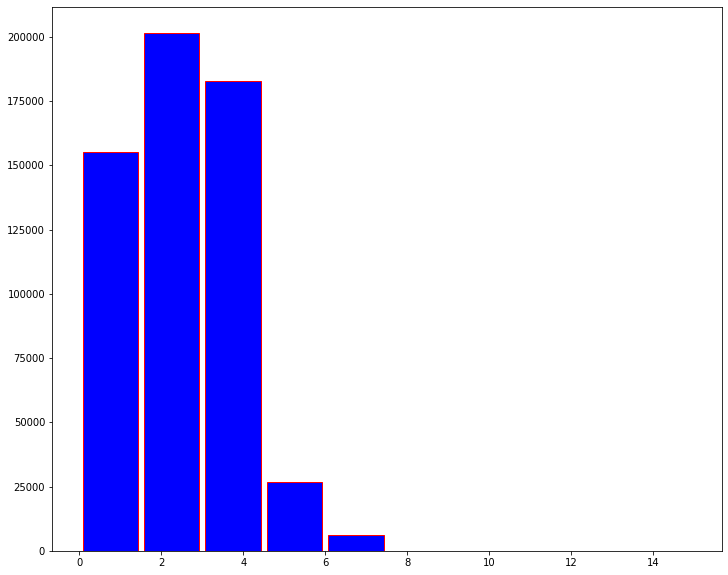

In [69]:
import numpy as np

from matplotlib import pyplot as plt

plt.figure(figsize=(12,10))
plt.hist(delais,align="mid",rwidth=0.9,color="b",edgecolor="red",label="delais")
plt.show()

## Ajouter des Features


##### On va créer de features et les analyser afin de voir si elles sont pertinentes pour construire les différents modèles


In [21]:
#On sépare la date de commande en date et heure
data['Date_commande'] = pd.to_datetime(data['datedecreationdecommande']).dt.date
data['Heure_commande'] = pd.to_datetime(data['datedecreationdecommande']).dt.hour

#On rajour le jour de semaine de la commande
data['Jour_semaine']= pd.to_datetime(data['datedecreationdecommande']).dt.weekday 

In [22]:
#On sépare la date de commande en jour, mois et année
data['Annee_C']= pd.to_datetime(data['datedecreationdecommande']).dt.year
data['Mois_C']= pd.to_datetime(data['datedecreationdecommande']).dt.month
data['Jour_C']= pd.to_datetime(data['datedecreationdecommande']).dt.day

#On transforme la variable du service en string a
data['Fournisseur']=data['providerservice_id'].astype(str)

In [23]:
lesJours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

Calendar=[]
for i in data['Jour_semaine']:
    #print(lesJours[i])
    Calendar.append(lesJours[i])

data['Jour_calendaire']= Calendar 


In [24]:
#On créé une variable qui va nous dire si oui ou non la commande a été effectué pendant les heures de travail
#On determine l'intervalle entre
data['heure_travail']= (data['Heure_commande']>8) &  (data['Heure_commande']<20)
data['heure_travail']= data['heure_travail'].astype(int)

In [25]:
data.dtypes

datedecreationdecommande    object
providerservice_id           int64
dateexpe                    object
délais                       int64
Date_commande               object
Heure_commande               int64
Jour_semaine                 int64
Annee_C                      int64
Mois_C                       int64
Jour_C                       int64
Fournisseur                 object
Jour_calendaire             object
heure_travail                int32
dtype: object

In [26]:
data2=data[['Jour_C','Mois_C','Jour_semaine','Heure_commande','heure_travail','Fournisseur','délais']]

In [27]:
data2.dtypes

Jour_C             int64
Mois_C             int64
Jour_semaine       int64
Heure_commande     int64
heure_travail      int32
Fournisseur       object
délais             int64
dtype: object

In [28]:
data2

,Jour_C,Mois_C,Jour_semaine,Heure_commande,heure_travail,Fournisseur,délais
0,1,11,4,11,1,48,1
1,1,11,4,11,1,48,1
2,1,11,4,10,1,48,1
3,1,11,4,14,1,48,1
4,1,11,4,13,1,48,1
...,...,...,...,...,...,...,...
572836,16,12,0,6,0,48,1
572837,16,12,0,6,0,48,1
572838,15,12,6,22,0,48,2
572839,15,12,6,20,0,48,2


In [29]:
data2['délais'].mean()

2.3175886467867888

In [30]:
data2.describe()

,Jour_C,Mois_C,Jour_semaine,Heure_commande,heure_travail,délais
count,572807.000000,572807.000000,572807.000000,572807.000000,572807.000000,572807.000000
mean,14.040017,11.412158,3.156484,15.333788,0.699010,2.317589
std,9.724833,0.492224,2.133390,4.758577,0.458689,1.236173
min,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,11.000000,1.000000,12.000000,0.000000,1.000000
50%,12.000000,11.000000,3.000000,16.000000,1.000000,2.000000
75%,24.000000,12.000000,5.000000,19.000000,1.000000,3.000000
max,30.000000,12.000000,6.000000,23.000000,1.000000,15.000000


### On étudie la corrélation entre les features

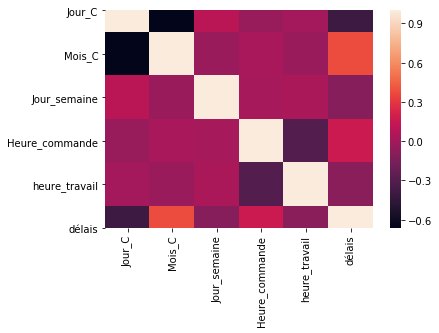

In [31]:
import seaborn as sns
sns.heatmap(data2.corr())

In [32]:
data.dtypes
data.corr()

,providerservice_id,délais,Heure_commande,Jour_semaine,Annee_C,Mois_C,Jour_C,heure_travail
providerservice_id,1.000000,0.023007,-0.013139,0.029341,NaN,-0.026252,0.023451,0.054768
délais,0.023007,1.000000,0.167806,-0.102732,NaN,0.382755,-0.392781,-0.090180
Heure_commande,-0.013139,0.167806,1.000000,0.026356,NaN,0.029974,-0.025944,-0.300761
Jour_semaine,0.029341,-0.102732,0.026356,1.000000,NaN,-0.023918,0.101491,0.036077
Annee_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mois_C,-0.026252,0.382755,0.029974,-0.023918,NaN,1.000000,-0.661563,-0.023091
Jour_C,0.023451,-0.392781,-0.025944,0.101491,NaN,-0.661563,1.000000,0.016685
heure_travail,0.054768,-0.090180,-0.300761,0.036077,NaN,-0.023091,0.016685,1.000000


##### On remarque q'il n'y a pas de grosse corrélation entre les paramètres

## Modèle


#### Linear Regression

In [33]:
import pandas as pd # Pour importer le tableau
import matplotlib.pyplot as plt # Pour tracer des graphiques
import numpy as np # Pour le calcul numérique
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression 
# le module scikit
from sklearn import datasets, linear_model, metrics

In [34]:
x = np.array(data2[['Jour_C','Mois_C','Jour_semaine','Heure_commande','heure_travail','Fournisseur']])
y = np.array(data2['délais'])

In [35]:
x

array([[1, 11, 4, 11, 1, '48'],
       [1, 11, 4, 11, 1, '48'],
       [1, 11, 4, 10, 1, '48'],
       ...,
       [15, 12, 6, 22, 0, '48'],
       [15, 12, 6, 20, 0, '48'],
       [15, 12, 6, 19, 1, '48']], dtype=object)

In [36]:
y

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [37]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.7, 
                                                    random_state=1)

In [38]:
reg = linear_model.LinearRegression() 
  
reg.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
y_pred_reg=reg.predict(X_test)

In [40]:
y_pred_reg2=[]
for i in y_pred_reg:
    y_pred_reg2.append(int(i))

In [41]:
np.array(y_pred_reg2)

array([3, 2, 1, ..., 2, 2, 1])

In [42]:
#plt.scatter(y_pred,y_test)

In [43]:
np.mean((y_pred_reg2 - y_test)**2)

1.5595426034691307

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(y_pred_reg2,y_test))
print(mean_absolute_error(y_pred_reg2,y_test))

1.5595426034691307
0.9340416245806991


###  On remarque que la target est une variable discrète donc ont peut appliquer des modèles de classifications

#### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [46]:
log = LogisticRegression(solver='liblinear', random_state=0)

In [47]:
log.fit(X_train, y_train) 

C:\Users\Takwa Aldroe\Anaconda3\Nouveau dossier\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
y_pred_log=log.predict(X_test)

In [49]:
y_pred_log2=[]
for i in y_pred_log:
    y_pred_log2.append(int(i))
np.array(y_pred_log2)

In [51]:
print(mean_squared_error(y_pred_log2,y_test))
print(mean_absolute_error(y_pred_log2,y_test))
print(accuracy_score(y_test,y_pred_log))

1.0207225069519783
0.7043956455052187
0.4244335540508523


#### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()

In [53]:
rfc.fit(X_train,y_train)

C:\Users\Takwa Aldroe\Anaconda3\Nouveau dossier\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
y_pred_rfc=rfc.predict(X_test)

In [55]:
score_rfc=accuracy_score(y_test,y_pred_rfc)

In [56]:
print(score_rfc)

0.69181100594815


####  Boosting

In [57]:
from xgboost import XGBClassifier
xgb=XGBClassifier()

xgb.fit(X_train,y_train)

y_pred_xgb=xgb.predict(X_test)

score_xgb=accuracy_score(y_test,y_pred_xgb)


In [58]:
print(score_xgb)

0.641781701644782


#### KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
list_1=[]
for i in range(1,21):
    knn=KNeighborsClassifier(n_neighbors=i)
    
    knn.fit(X_train,y_train)
    
    preds=knn.predict(X_test)

    scores=accuracy_score(y_test,preds)
    
    list_1.append(scores)
    

max(list_1)

0.6717070068459841

In [60]:
max(list_1)

0.6717070068459841

#### NaiveBayes

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB(alpha=1.9)         

mnb.fit(X_train,y_train)

y_pred_mnb= mnb.predict(X_test)
score_mnb=accuracy_score(y_pred_mnb,y_test)


print("Accuracy Score for Naive Bayes : ", score_mnb)

Accuracy Score for Naive Bayes :  0.36188694773858066


##### La meileur accuracy est celle de random forest